In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #맷플롯립에서 3차원 플롯을 그리는 용도
from matplotlib import cm               #cm 모듈은 데이터 포인트에 색상을 입히는데 사용
import numpy as np

In [40]:
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device : ", DEVICE)

Using Device :  cuda


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!pwd

/content/drive/MyDrive/torch_tutorial/3min_torch/6ch_AE


In [11]:
%cd /content/drive/MyDrive/torch_tutorial/3min_torch/6ch_AE/

/content/drive/MyDrive/torch_tutorial/3min_torch/6ch_AE


In [20]:
train_set = datasets.FashionMNIST(
  root = '/content/drive/MyDrive/torch_tutorial/3min_torch/6ch_AE',
  train = True,
  download = True,
  transform = transforms.ToTensor(),
)


Extracting /content/drive/MyDrive/torch_tutorial/3min_torch/6ch_AE/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/torch_tutorial/3min_torch/6ch_AE/FashionMNIST/raw




Extracting /content/drive/MyDrive/torch_tutorial/3min_torch/6ch_AE/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/torch_tutorial/3min_torch/6ch_AE/FashionMNIST/raw




Extracting /content/drive/MyDrive/torch_tutorial/3min_torch/6ch_AE/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/torch_tutorial/3min_torch/6ch_AE/FashionMNIST/raw




Extracting /content/drive/MyDrive/torch_tutorial/3min_torch/6ch_AE/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/torch_tutorial/3min_torch/6ch_AE/FashionMNIST/raw

Processing...
Done!


In [22]:
train_loader = torch.utils.data.DataLoader(
  dataset = train_set,
  batch_size = BATCH_SIZE,
  shuffle = True,
  num_workers = 2,
)

In [50]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(28 * 28, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 3),

    )
    self.decoder = nn.Sequential(
        nn.Linear(3, 16),
        nn.ReLU(),
        nn.Linear(16, 32),
        nn.ReLU(),
        nn.Linear(32, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 28 * 28),
        nn.Sigmoid(),
    )
    
  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [51]:
auto_encoder = AutoEncoder().to(DEVICE)
optimizer = torch.optim.Adam(auto_encoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [52]:
view_data = train_set.data[:5].view(-1, 28 * 28)
view_data = view_data.type(torch.FloatTensor) / 255.

In [53]:
def train(auto_encoder, train_loader):
  auto_encoder.train()
  for step, (x, label) in enumerate(train_loader):
    x = x.view(-1, 28 * 28).to(DEVICE)
    y = x.view(-1, 28 * 28).to(DEVICE)
    label = label.to(DEVICE)

    encoded, decoded = auto_encoder(x)

    loss = criterion(decoded, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

[EPOCHS 1]


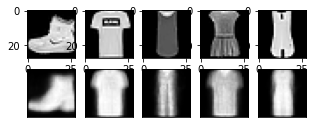

[EPOCHS 2]


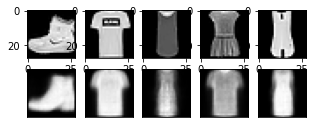

[EPOCHS 3]


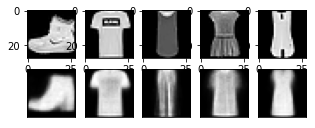

[EPOCHS 4]


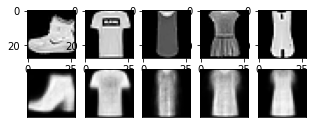

[EPOCHS 5]


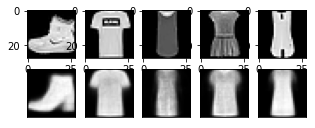

[EPOCHS 6]


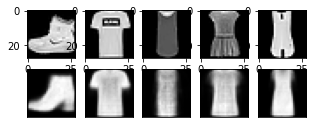

[EPOCHS 7]


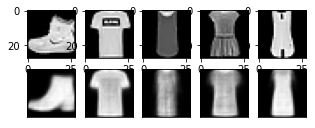

[EPOCHS 8]


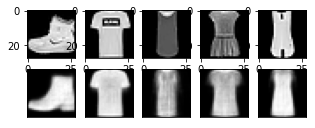

[EPOCHS 9]


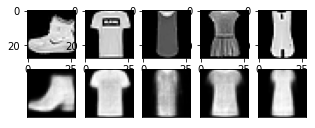

[EPOCHS 10]


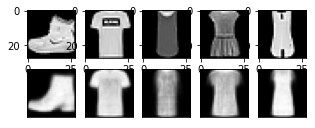

In [54]:
for epoch in range(1, EPOCH + 1):
  train(auto_encoder, train_loader)

  test_x = view_data.to(DEVICE)
  _, decoded_data = auto_encoder(test_x)

  f, a = plt.subplots(2, 5, figsize=(5, 2))
  print("[EPOCHS {}]".format(epoch))

  for i in range(5):
    img = np.reshape(view_data.data.numpy()[i], (28, 28))
    a[0][i].imshow(img, cmap='gray')
  
  for i in range(5):
    img = np.reshape(decoded_data.to('cpu').data.numpy()[i], (28, 28))
    a[1][i].imshow(img, cmap='gray')
    a[1][i].set_xticks(())
    a[1][i].set_yticks(())
  plt.show()

latent space 사이즈가 3밖에 안되어서 성능이 구리다   

In [42]:
view_data = train_set.data[:200].view(-1, 28 * 28)
view_data = view_data.type(torch.FloatTensor) / 255.
test_x = view_data.to(DEVICE)
encoded_data, _ = auto_encoder(test_x)
encoded_data = encoded_data.to("cpu")

In [43]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

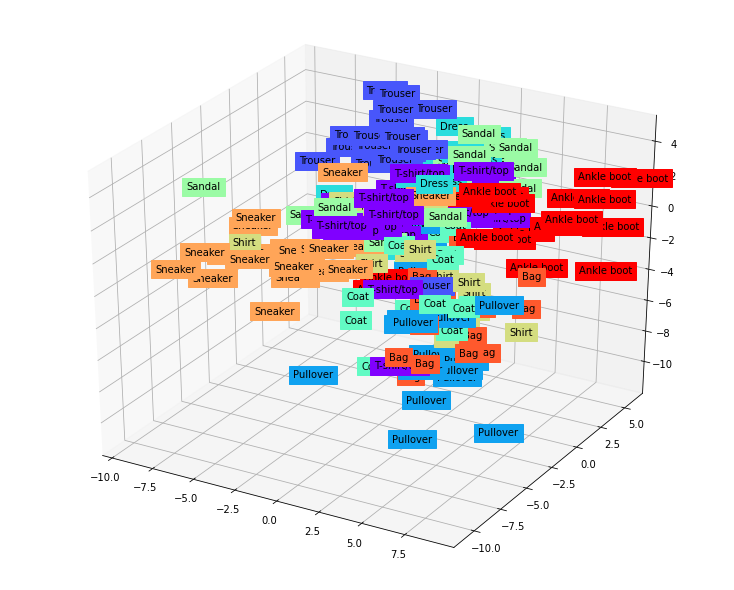

In [49]:
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)

X = encoded_data.data[:,0].numpy()
Y = encoded_data.data[:,1].numpy()
Z = encoded_data.data[:,2].numpy()

labels = train_set.targets[:200].numpy()

for x, y, z, s in zip(X, Y, Z, labels):
  name = CLASSES[s]
  color = cm.rainbow(int(255 * s / 9))
  ax.text(x, y, z, name, backgroundcolor=color)

ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())

plt.show()

해당 AE는 추후 시각화를 위해 일부러 latent space를 3차원으로 제한한 듯 하다  

하지만 다른 AE들을 살펴보면 기본적으로 latent space의 size를 10, 64 등  

적어도 두 자릿수를 넘기는 모습을 볼 수있다. 

눈으로 볼 수 있는건 3차원이 끝이기때문에 일부러 3차원으로 압축한것이겠지?  

10 or 64차원으로 압축한 latent space를 위처럼 눈으로 볼 수 있는 방법은 없을까?  